Load the liabrary

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

Load data

In [2]:
df = pd.read_csv("../data/laptop_final.csv")
print(df.head(5))
print(df.columns)

                                                link  \
0  https://laptopmedia.com/laptop-specs/asus-rog-...   
1  https://laptopmedia.com/laptop-specs/asus-rog-...   
2  https://laptopmedia.com/laptop-specs/asus-rog-...   
3  https://laptopmedia.com/laptop-specs/asus-rog-...   
4  https://laptopmedia.com/laptop-specs/asus-rog-...   

                       name  Display Size  Resolution: width  \
0        ASUS ROG Strix G17          17.3             2560.0   
1  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
2  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
3  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
4        ASUS ROG Strix G17          17.3             2560.0   

   Resolution: height  Refresh Rate       Panel Type  Disk Capacity  SSD  HDD  \
0              1440.0         240.0     IPS + G-Sync         2000.0  1.0  0.0   
1              1600.0         240.0   IPS + FreeSync        16000.0  1.0  0.0   
2              1600.0         240.0

In [3]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df=df.drop(columns=["link","name","Total Score","Work Score","Portability Score","Play Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df = df.drop_duplicates()

Drop nan values

In [4]:
df.isnull().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 256
RAM Type                                   26332
OS                                           659
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [5]:
df2 = df.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is:{} and after drop nan values is:{}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is:148514 and after drop nan values is:77994


Add more features following our knowledge about laptop architecture

In [6]:
# Add the aspect ratio for each laptop, equals (width/ height)
df2['Aspect Ratio'] = df2['Resolution: width'] / df2['Resolution: height']
# Add the pixel density for each laptop, equals sqrt(width^2 + height ^2) / display size
df2['Pixel Density'] = ((df2['Resolution: width']**2 + df2['Resolution: height']**2)**0.5) / df2['Display Size']
# Add the gpu performance for each laptop, equals memory size * memory frequency.
df2['GPU Performance'] = df2['GPU: Memory Size'] * df2['GPU: Memory Frequency (MHz)']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18072\2442813279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Aspect Ratio'] = df2['Resolution: width'] / df2['Resolution: height']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18072\2442813279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Pixel Density'] = ((df2['Resolution: width']**2 + df2['Resolution: height']**2)**0.5) / df2['Display Size']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18072\2442813279.py:6: SettingWithCopyWarning: 
A valu

Divide into train test split before encoding to prevent overfiting

In [7]:
target="Display Score"
X=df2.drop(columns=[target])
y=df2[target]

In [8]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

Encode categorical columns using target encoding

In [9]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df2[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [10]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

Features Selection

In [23]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]+[
                        "Aspect Ratio","Pixel Density","GPU Performance"
                    ]            
categorical_features=list(set(df2.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Body material: magnesium alloy', 'RAM Type', 'Security Lock slot', 'GPU: Architecture', 'Body material: matte', 'Card Reader', 'Body material: plastic / polycarbonate', 'Body material: plastic', 'OS', 'Optane', 'SSHD', 'Body material: carbon', 'Panel Type', 'Fingerprint reader', 'Body material: glass fiber', 'Backlit keyboard', 'SSD', 'Body material: aluminum', 'HDD', 'Body material: black synthetic material', 'Body material: magnesium-lithium alloy', 'GPU: Memory Type']
22


In [24]:
# Normalization
normalized_X_train = X_train.copy()
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,Aspect Ratio,Pixel Density,GPU Performance
239106,1.446414,3.912324,3.322960,0.208321,7.444047,-0.371588,1.0,0.0,0.0,0.0,...,7.480438,-0.156851,0.671995,0.154399,1.124789,0.150089,0.740619,0.476996,2.919189,-0.183147
71605,-1.578167,-1.532585,-1.441881,-0.679976,2.480449,-0.663655,1.0,0.0,0.0,0.0,...,6.676931,-0.530518,-0.884019,-0.984167,-0.958441,-0.377356,-0.918719,0.489126,-1.141572,-0.413201
115074,-1.578167,-0.313312,-0.373900,-0.679976,7.444047,-0.566299,1.0,0.0,0.0,0.0,...,6.676931,-0.530518,-0.884019,-0.984167,-0.958441,-0.377356,-0.918719,0.476996,0.150467,-0.413201
25443,0.254912,1.095233,1.406070,0.874544,7.444047,-0.000421,1.0,0.0,0.0,0.0,...,7.480438,2.458816,3.265351,0.296720,1.819199,1.204978,2.192540,-2.007278,1.041762,4.494606
79451,1.446414,-0.313312,-0.373900,-0.679976,7.444047,-0.000421,1.0,0.0,0.0,0.0,...,6.676931,-0.530518,-0.884019,-0.984167,-0.958441,-0.377356,-0.918719,0.476996,-0.703437,-0.413201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226220,1.446414,-0.313312,-0.373900,1.984915,7.444047,1.520759,1.0,0.0,0.0,0.0,...,7.480438,2.458816,1.190666,0.609826,1.819199,-0.641078,1.155453,0.476996,-0.703437,2.040702
221612,-0.111703,-0.313312,-0.373900,0.563640,7.444047,-0.566299,1.0,0.0,0.0,0.0,...,7.480438,-0.156851,1.190666,0.752146,1.819199,0.150089,1.466579,0.476996,-0.308664,-0.106463
58233,0.254912,-0.313312,0.036863,-0.679976,7.444047,-0.566299,1.0,0.0,0.0,0.0,...,6.676931,-0.530518,-0.884019,-0.984167,-0.958441,-0.377356,-0.918719,-2.007278,-0.300194,-0.413201
93896,-0.111703,-0.313312,-0.373900,0.208321,7.444047,0.379874,1.0,1.0,0.0,0.0,...,7.480438,1.177673,0.153324,1.093716,0.430379,-1.695968,-0.192759,0.476996,-0.308664,0.287914


Using mutual info and anova to find the most relevant categorical features

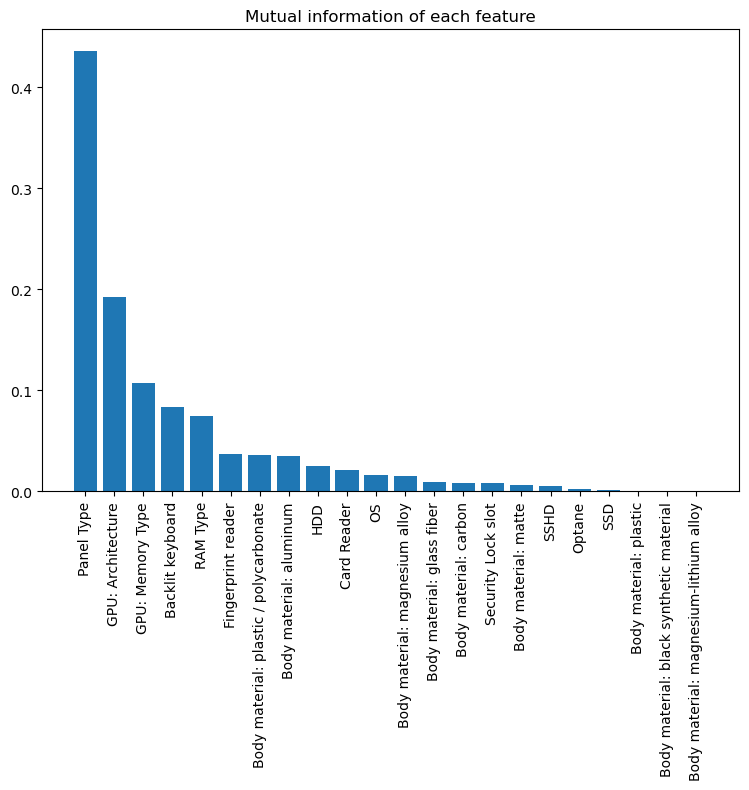

In [25]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 4  7 19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


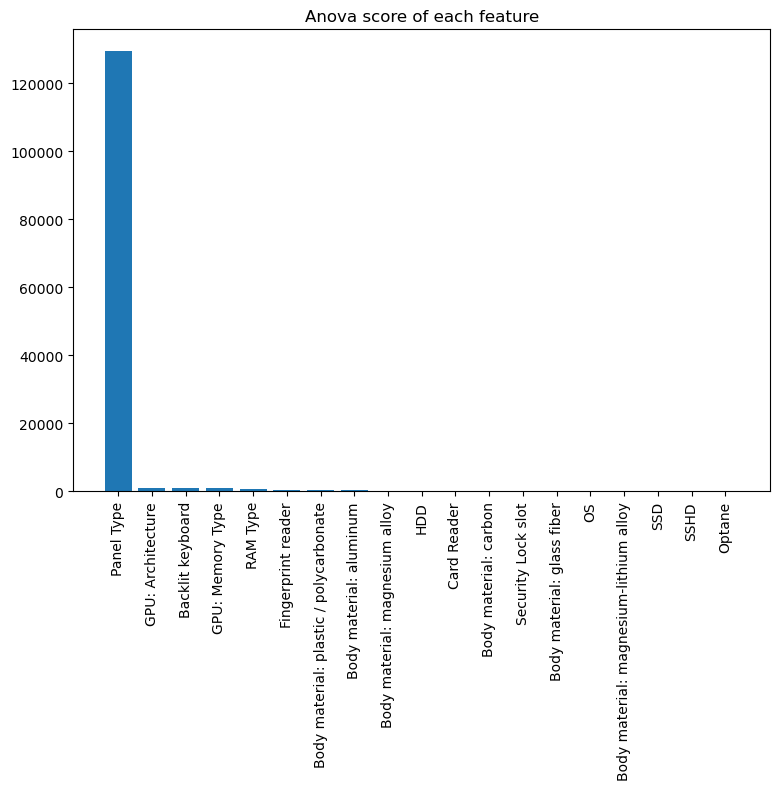

In [26]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

Using pearson correlation, spearman to find the most relevant in numerical features

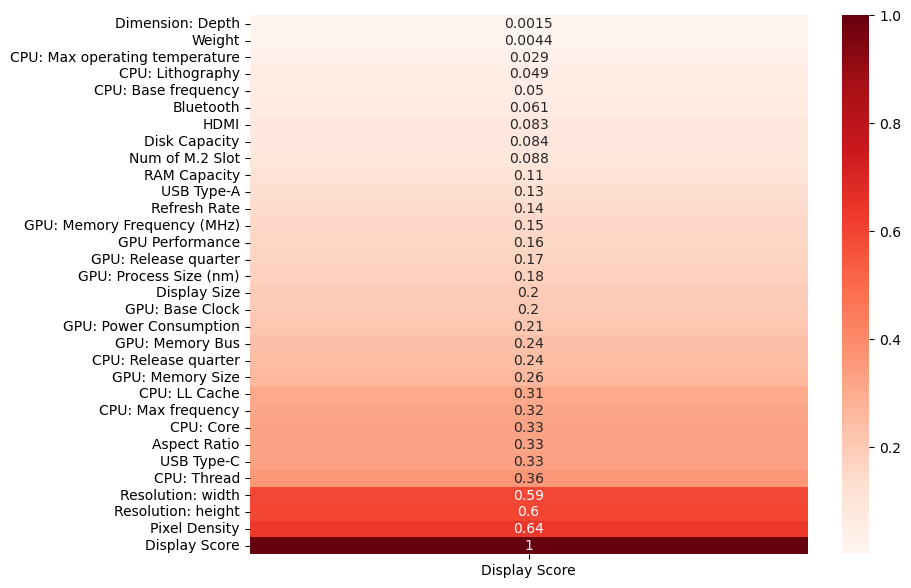

In [27]:
# using pearsonscore
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

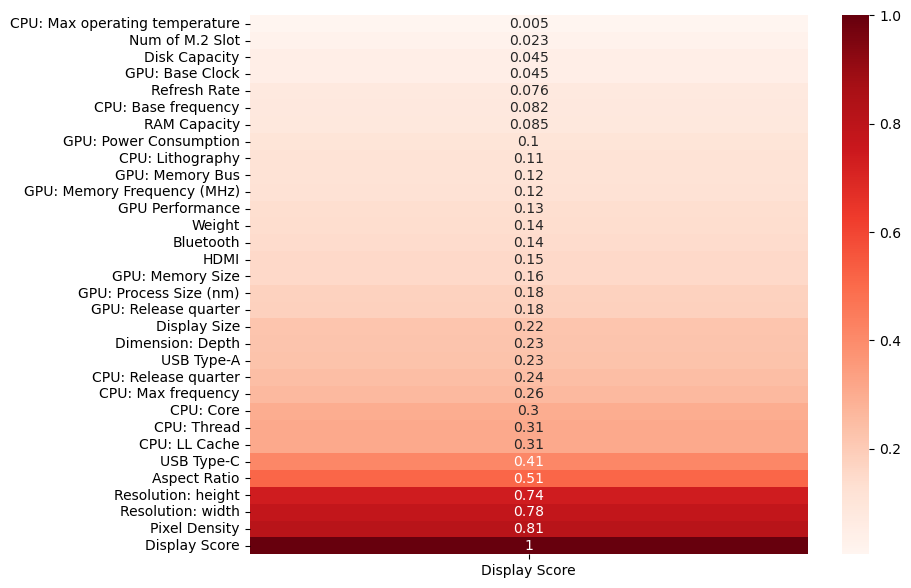

In [28]:
# using spearman score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

Using Random Forest to choose important features in 2 groups

In [29]:
# Choose candidate features in 2 groups
candidate_num_features = target_correlation[target].abs().sort_values(ascending=False).index[1:6].tolist()
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['Panel Type', 'GPU: Architecture', 'GPU: Memory Type', 'Backlit keyboard', 'RAM Type', 'Pixel Density', 'Resolution: width', 'Resolution: height', 'Aspect Ratio', 'USB Type-C']


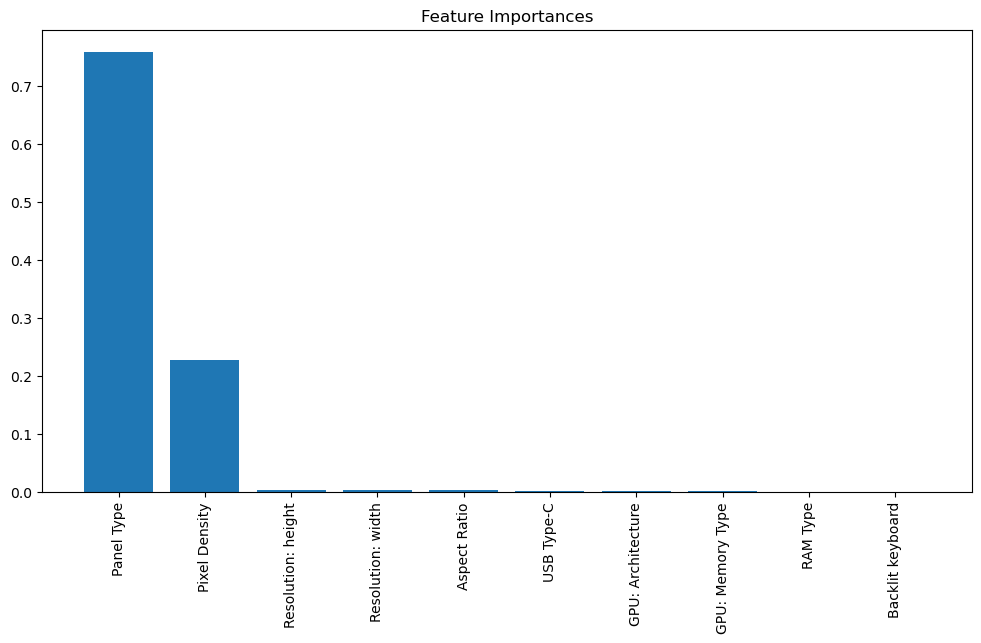

In [30]:
candidate_X = X_train[candidate_featues]
model = RandomForestRegressor()
model.fit(candidate_X, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [22]:
#Choose importatn features based on the importance score in RF
choosen_features = ["Panel Type","Pixel Density"]

Outlier Detection

In [20]:
choosen_num_features = "Pixel Density"
choosen_cat_features = "Panel Type"

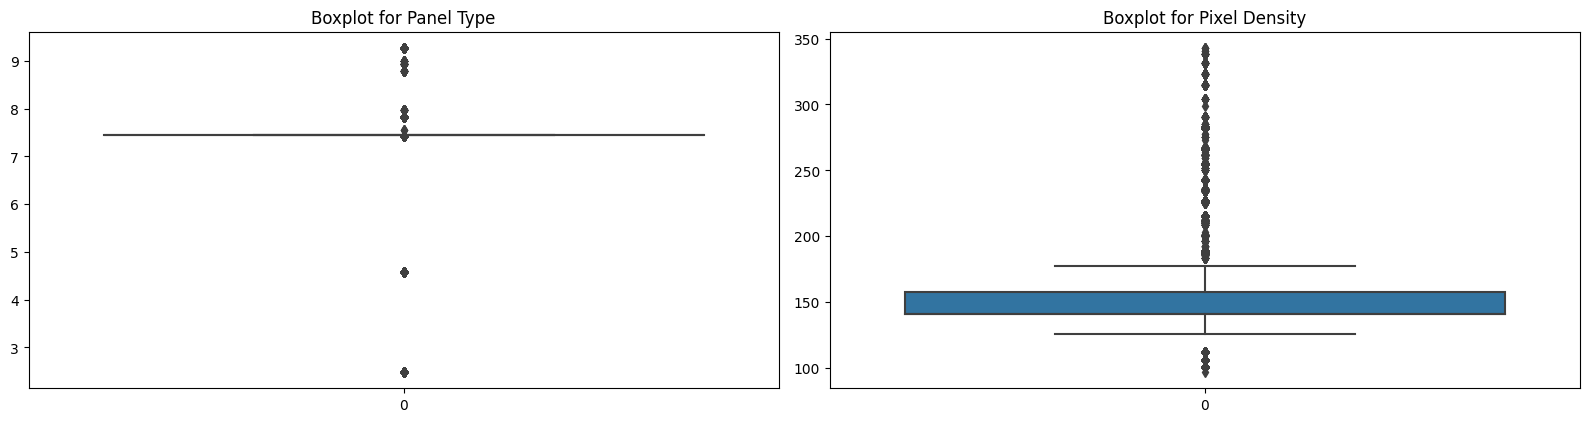

In [21]:
plt.figure(figsize=(16,12))
for i,var in enumerate(choosen_features):
  plt.subplot(3,2,i+1)
  sns.boxplot(X_train[var])
  plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()

Numerical features

<Axes: xlabel='Pixel Density', ylabel='Count'>

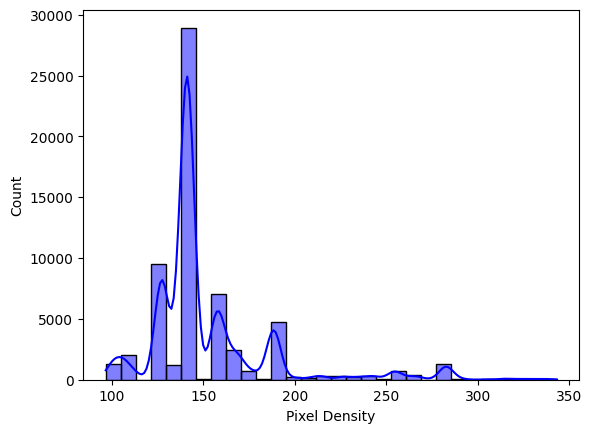

In [22]:
sns.histplot(X_train[choosen_num_features], kde=True, bins=30, color='blue')

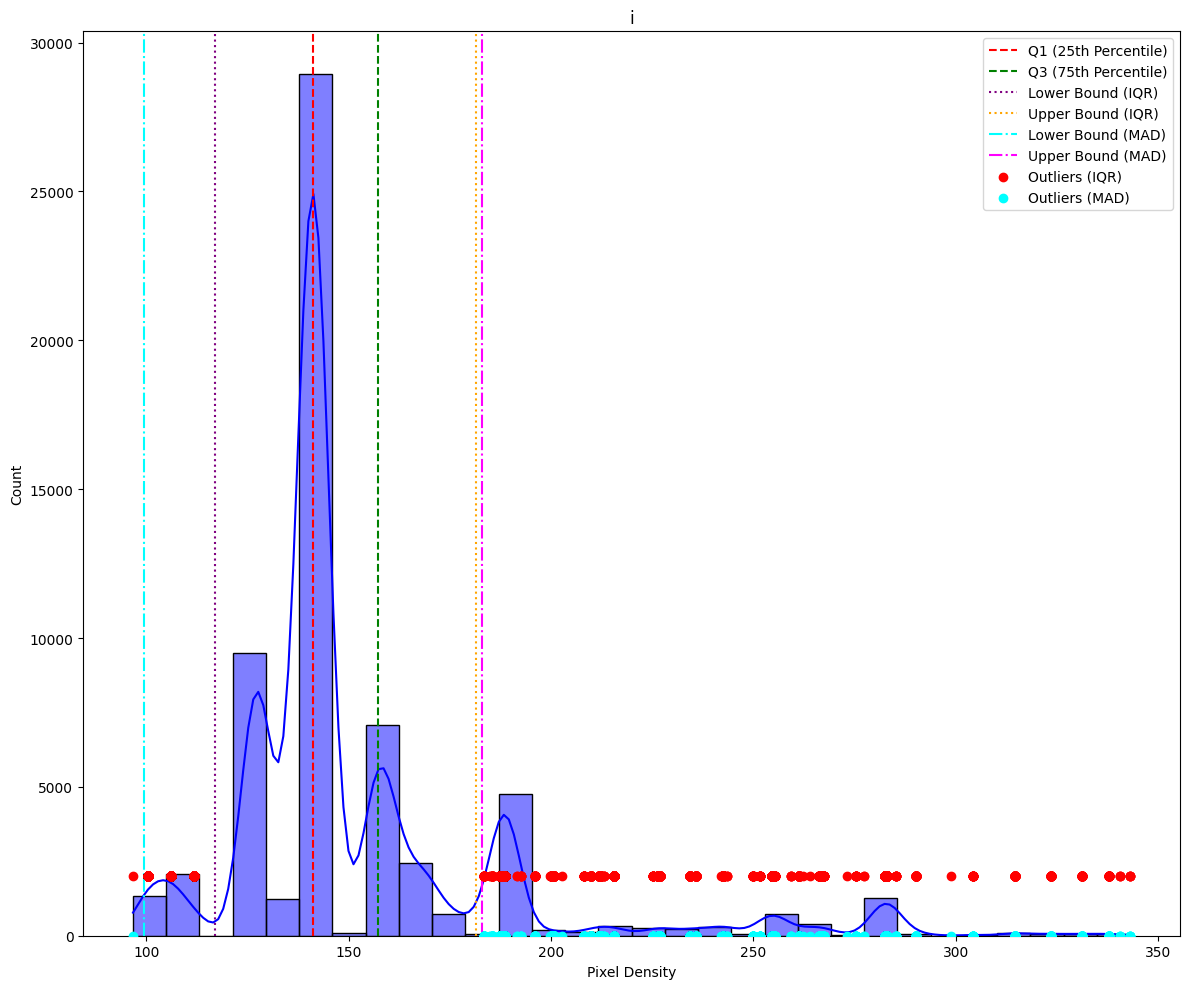

In [23]:
# Suppose the removal of outlier based on IQR and MAD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def detect_outliers(data):
    # IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    # MAD
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    lower_bound_mad = median - 3 * mad
    upper_bound_mad = median + 3 * mad
    return Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad
def plot_distribution(data, ax, title):
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(data)
    sns.histplot(data, kde=True, bins=30, color='blue', ax=ax)
    ax.axvline(Q1, color="red", linestyle="--", label="Q1 (25th Percentile)")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3 (75th Percentile)")

    ax.axvline(lower_bound_iqr, color="purple", linestyle=":", label="Lower Bound (IQR)")
    ax.axvline(upper_bound_iqr, color="orange", linestyle=":", label="Upper Bound (IQR)")
    ax.axvline(lower_bound_mad, color="cyan", linestyle="-.", label="Lower Bound (MAD)")
    ax.axvline(upper_bound_mad, color="magenta", linestyle="-.", label="Upper Bound (MAD)")

    iqr_outliers = data[(data < lower_bound_iqr) | (data > upper_bound_iqr)]
    mad_outliers = data[(data < lower_bound_mad) | (data > upper_bound_mad)]
    ax.scatter(iqr_outliers, [2000] * len(iqr_outliers), color="red", label="Outliers (IQR)", zorder=5)
    ax.scatter(mad_outliers, [0] * len(mad_outliers), color="cyan", label="Outliers (MAD)", zorder=5)
    ax.set_title(title)
    ax.legend()
fig, axes = plt.subplots(figsize=(12, 10))
plot_distribution(X_train[choosen_num_features], axes, choosen_num_features[i])
plt.tight_layout()
plt.show()


In [24]:
Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train[choosen_num_features])
outliers_iqr = X_train[(X_train[choosen_num_features] < lower_bound_iqr) | (X_train[choosen_num_features]> upper_bound_iqr)]
print("Number of outlier based on IQR technique in feature "+ choosen_num_features+": "+"{}".format(len(outliers_iqr)))
outliers_mad = X_train[(X_train[choosen_num_features] < lower_bound_mad) | (X_train[choosen_num_features]> upper_bound_mad)]
print("Number of outlier based on MAD technique in feature "+ choosen_num_features+": "+"{}".format(len(outliers_mad)))

Number of outlier based on IQR technique in feature Pixel Density: 12417
Number of outlier based on MAD technique in feature Pixel Density: 9040


Categorical features

In [34]:
threshold_percentage = 1 # put threshold percentage of 1 %

freq = X_train[choosen_cat_features].value_counts(normalize=True) * 100  
rare_categories = freq[freq < threshold_percentage].index.tolist()
num_outlier = X_train[choosen_cat_features].isin(rare_categories).sum()
print(choosen_cat_features + ": "+ str(num_outlier))
reduced_X_train = X_train[~X_train[choosen_cat_features].isin(rare_categories)]
reduced_y_train = y_train[X_train.index] 
print(reduced_X_train.shape[0])
print(reduced_y_train.shape[0])


Panel Type: 408
61987
62395


Plot the relationship between the features and the target

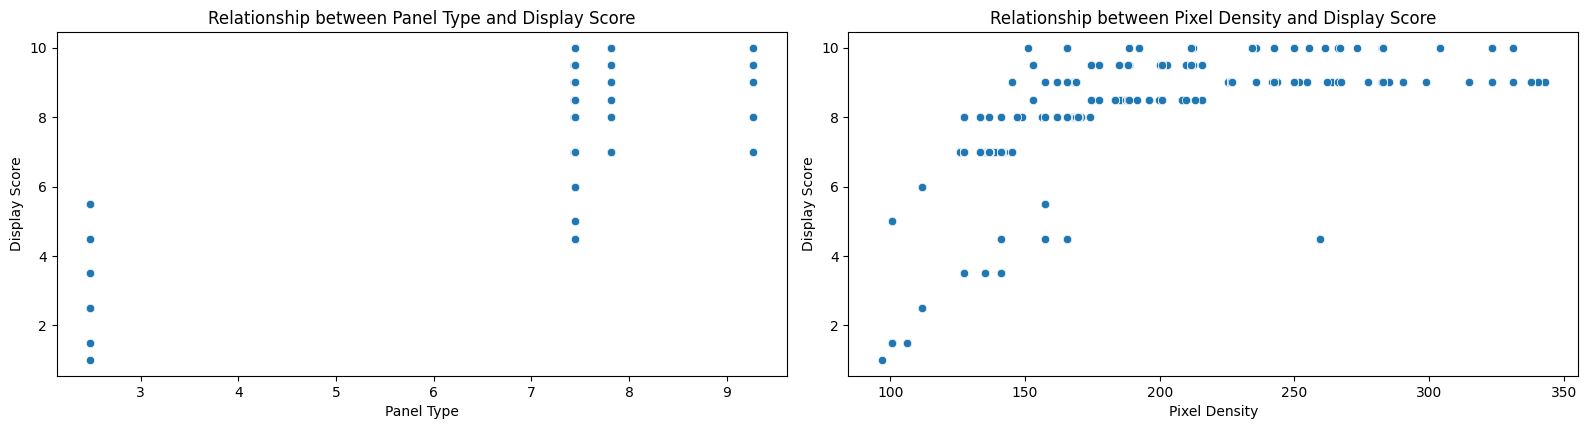

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
for i,var in enumerate(choosen_features):
  plt.subplot(3,2,i+1)
  sns.scatterplot(x=reduced_X_train[var], y=reduced_y_train)
  plt.title(f'Relationship between {var} and Display Score')
plt.tight_layout()
plt.show()

Fine-tuning hyperparameters

In [35]:
def plot(title, xlabel, X, Y, ylabel = "mse"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.scatter(X,Y)

In [40]:
scaler = StandardScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.transform(X_test)

In [41]:
y_scaler = StandardScaler()
normalized_y_train = y_scaler.fit_transform(reduced_y_train.to_numpy().reshape(-1, 1))

Gradient Boosting Regression

In [ ]:
title = "Change of n_estimators in Gradient Boosting Regression"
xlabel = "n_estimators"
X = []
Y = []
for n_estimators in tqdm([100, 300, 500,700]):
    model = GradientBoostingRegressor(n_estimators=n_estimators)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_estimators))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
  0%|          | 0/2 [00:04<?, ?it/s]


KeyboardInterrupt: 

KNN Regression

100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


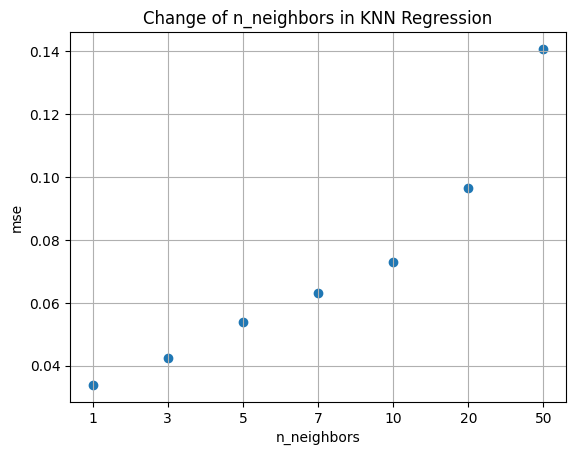

In [42]:
title = "Change of n_neighbors in KNN Regression"
xlabel = "n_neighbors"
X = []
Y = []
scaler = StandardScaler()
normalized_y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
for n_neighbors in tqdm([1, 3, 5, 7, 10, 20, 50]):
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_neighbors))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

Random Forest Regression 

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
 20%|██        | 1/5 [00:07<00:30,  7.58s/it]C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,)

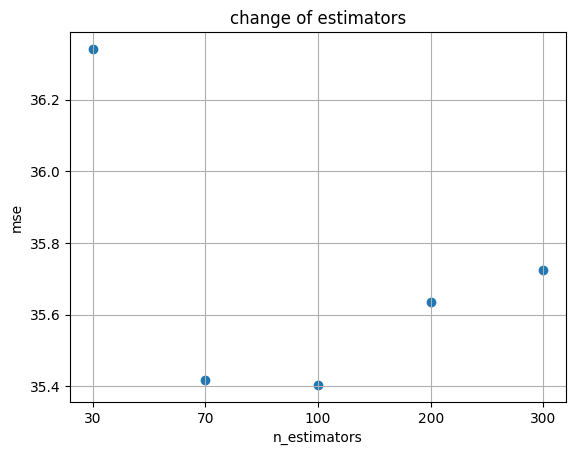

In [ ]:
title = "change of estimators"
xlabel = "n_estimators"
X = []
Y = []
criterion = 'squared_error'
scaler = StandardScaler()
normalized_y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
for n_estimators in tqdm([30, 70, 100, 200, 500]):
    model = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_estimators))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

In [ ]:
title = "Change of Estimators (SVM Regression)"
xlabel = "C (Regularization Parameter)"
X = []
Y = []
for C_value in tqdm([0.1, 1, 10, 100, 1000]):
    model = SVR(C=C_value, kernel='rbf', epsilon=0.1)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(C_value))
    Y.append(mse)

plot(title, xlabel, X, Y)
plt.show()

Results of each model in this dataset after fine-tuned hyper-parameters

In [ ]:
models = {
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting' : GradientBoostingRegressor()
}

def train(X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Training and evaluating {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - Mean Squared Error: {mse}, R-squared: {r2}")